In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in divide")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# globals
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Case study 1: Educational Outcomes for Hearing-impaired Children

As a motivating example, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes.

### The Data

This anonymized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled in programs focused on supporting listening and spoken language development. Researchers are interested in discovering factors related to improvements in educational outcomes within these programs.

There is a suite of available predictors, including:

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

The outcome variable is a standardized test score in one of several learning domains.

In [3]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


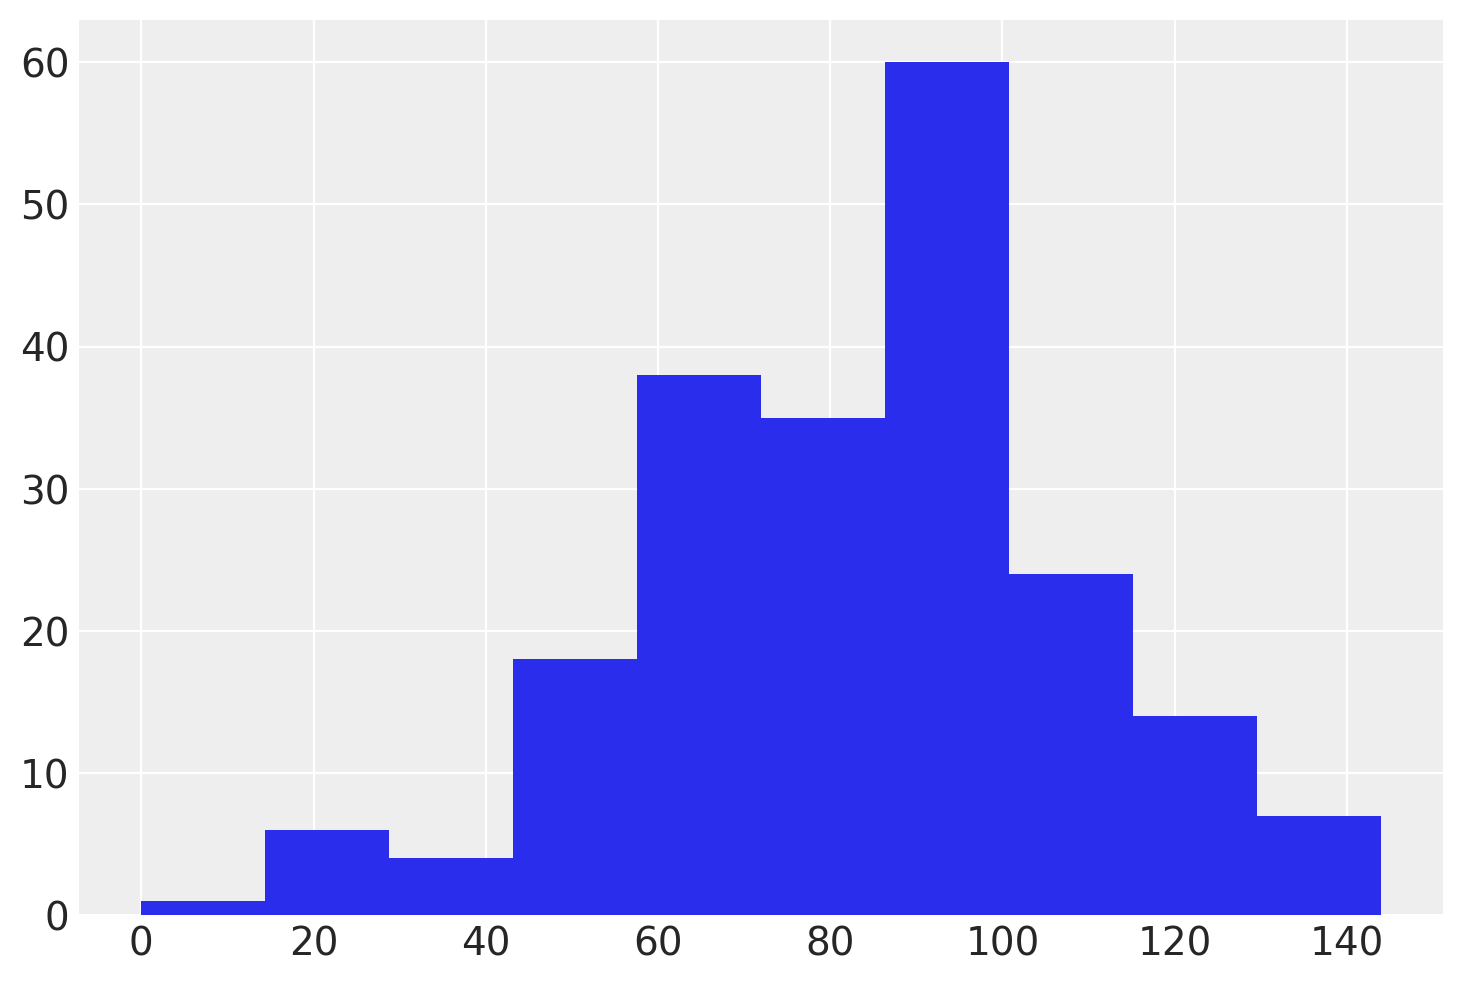

In [4]:
test_scores["score"].hist();

In [5]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

### The Model

This is a more realistic problem than a simple linear regression model, as we are now dealing with a **multivariate regression** model. However, while there are several potential predictors in the LSL-DR dataset, it is difficult *a priori* to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is *regularization*, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes.

You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the *hierarchical regularized horseshoe*, which uses two regularization strategies, one global and a set of local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

The horseshoe prior for each regression coefficient $\beta_i$ looks like this:

$$\beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)$$

where $\sigma$ is the prior on the error standard deviation that will also be used for the model likelihood. Here, $\tau$ is the global shrinkage parameter and $\tilde{\lambda}_i$ is the local shrinkage parameter. Let's start global: for the prior on $\tau$ we will use a Half-StudentT distribution, which is a reasonable choice becuase it is heavy-tailed.

$$
\tau \sim \textrm{Half-StudentT}_{2} \left(\frac{D_0}{D - D_0} \cdot \frac{\sigma}{\sqrt{N}}\right).
$$

One catch is that the parameterization of the prior requires a pre-specified value $D_0$, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let's use half the number of predictors as our guess:

In [6]:
D0 = int(D / 2)

Meanwhile, the local shrinkage parameters are defined by the ratio:

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}.$$

To complete this specification, we need priors on $\lambda_i$ and $c$;  as with the global shrinkage, we use a long-tailed $\textrm{Half-StudentT}_5(1)$  on the $\lambda_i$. We need $c^2$ to be strictly positive, but not necessarily long-tailed, so an inverse gamma prior on $c^2$, $c^2 \sim \textrm{InverseGamma}(1, 1)$ fits the bill.

Finally, to allow the NUTS sampler to sample the $\beta_i$ more efficiently, we will re-parameterize it as follows:

$$
\begin{align*}
    z_i
        & \sim N(0, 1), \\
     \beta_i
         & = z_i \cdot \tau \cdot \tilde{\lambda_i}.
\end{align*}
$$

You will run into this reparameterization a lot in practice.


### Model Specification

Specifying the model in PyMC mirrors its statistical specification. This model employs a couple of new distributions: the {class}`~pymc.HalfStudentT` distribution for the $\tau$ and $\lambda$ priors, and the `InverseGamma` distribution for the $c^2$ variable.

In PyMC, variables with purely positive priors like {class}`~pymc.InverseGamma` are transformed with a log transform. This makes sampling more robust. Behind the scenes, a variable in the unconstrained space (named `<variable-name>_log`) is added to the model for sampling. Variables with priors that constrain them on two sides, like {class}`~pymc.Beta` or {class}`~pymc.Uniform`, are also transformed to be unconstrained but with a log odds transform.

We are also going to take advantage of named dimensions in PyMC and ArviZ by passing the input variable names into the model as coordinates called "predictors". This will allow us to pass this vector of names as a replacement for the `shape` integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

Let's encode this model in PyMC:

In [7]:
with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + pt.dot(X.values, beta), sigma, observed=y.values)

Notice that we have wrapped the calculation of `beta` in a {class}`~pymc.Deterministic` PyMC class. You can read more about this in detail below, but this ensures that the values of this deterministic variable is retained in the sample trace.

Also note that we have declared the {class}`~pymc.Model` name `test_score_model` in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

Once the model is complete, we can look at its structure using GraphViz, which plots the model graph. It's useful to ensure that the relationships in the model you have coded are correct, as it is easy to make coding mistakes.

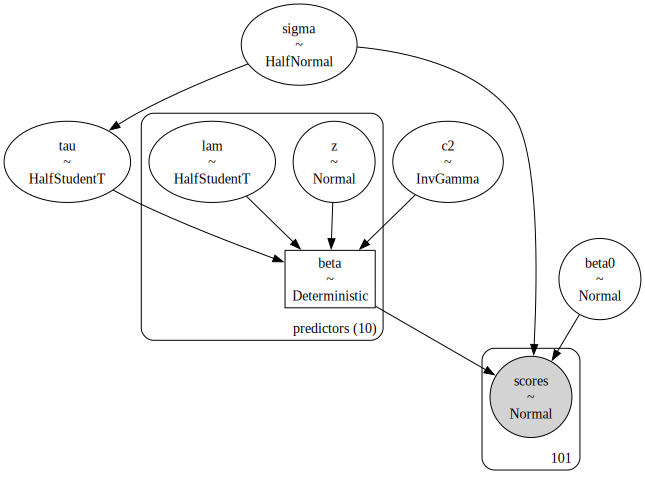

In [8]:
import os
# https://graphviz.org/download/
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
pm.model_to_graphviz(test_score_model)
# lam and z are within predictors due to their shapes

Before we proceed further, let's see what the model does before it sees any data. We can conduct *prior predictive sampling* to generate simulated data from the model. Then, let's compare these simulations to the actual test scores in the dataset.

In [9]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


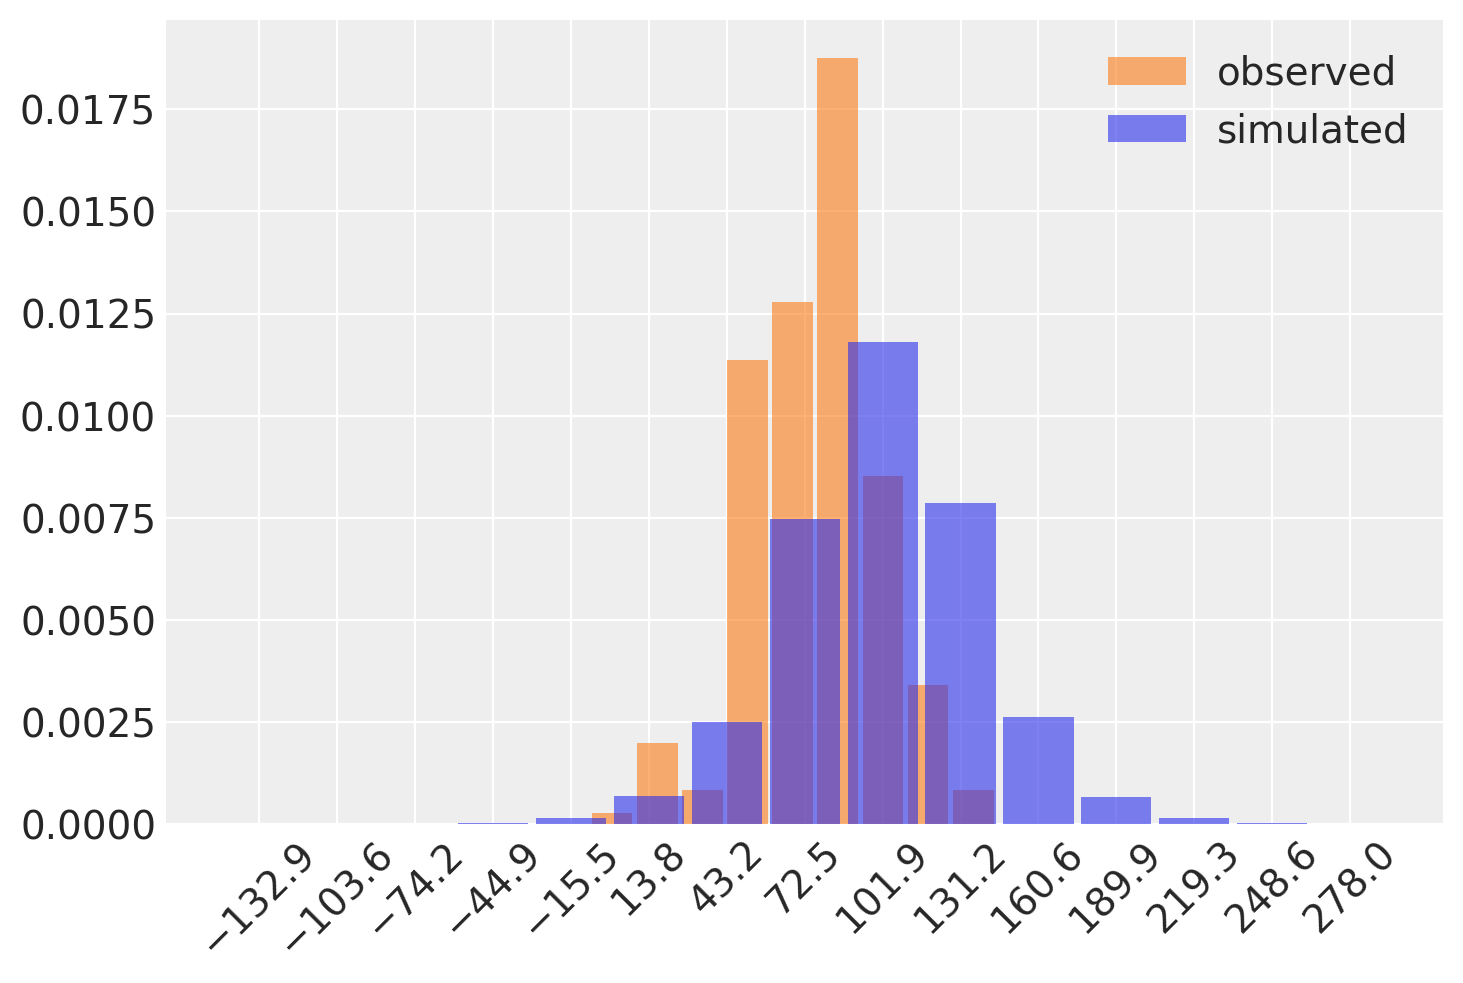

In [10]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)
plt.xticks(rotation=45);

How do we know if this is reasonable or not? This requires some domain knowledge of the problem. Here, we are trying to predict the outcomes of test scores. If our model was predicting values in the thousands, or lots of negative values, while excluding scores that are plausible, then we have misspecified our model. You can see here that the support of the distribution of simulated data completely overlaps the support of the observed distribution of scores; this is a good sign! There are a few negative values and a few that are probably too large to be plausible, but nothing to worry about.

### Model Fitting

Now for the easy part: PyMC's "Inference Button" is the call to `sample`. We will let this model tune for a little longer than the default value (1000 iterations). This gives the NUTS sampler a little more time to tune itself adequately.

In [11]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)
    # tune controls the number of tuning steps

c:\Users\manuz\Desktop\Adm\Projects\pymc_BayesianEstimation\.venv\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\manuz\Desktop\Adm\Projects\pymc_BayesianEstimation\.venv\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 136 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Notice that we have a few warnings here about divergences. These are samples where NUTS was not able to make a valid move across the posterior distribution, so the resulting points are probably not representative samples from the posterior. There aren't many in this example, so it's nothing to worry about, but let's go ahead and follow the advice and increase `target_accept` from its default value of 0.9 to 0.99.

In [12]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

c:\Users\manuz\Desktop\Adm\Projects\pymc_BayesianEstimation\.venv\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\manuz\Desktop\Adm\Projects\pymc_BayesianEstimation\.venv\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 417 seconds.


Since the target acceptance rate is larger, the algorithm is being more conservative with its leapfrog steps, making them smaller. The price we pay for this is that each sample takes longer to complete. However, the warnings are now gone, and we have a clean posterior sample!

#### Model Checking

A simple first step in model checking is to visually inspect our samples by looking at the traceplot for the univariate latent parameters to check for obvious problems. These names can be passed to `plot_trace` in the `var_names` argument.

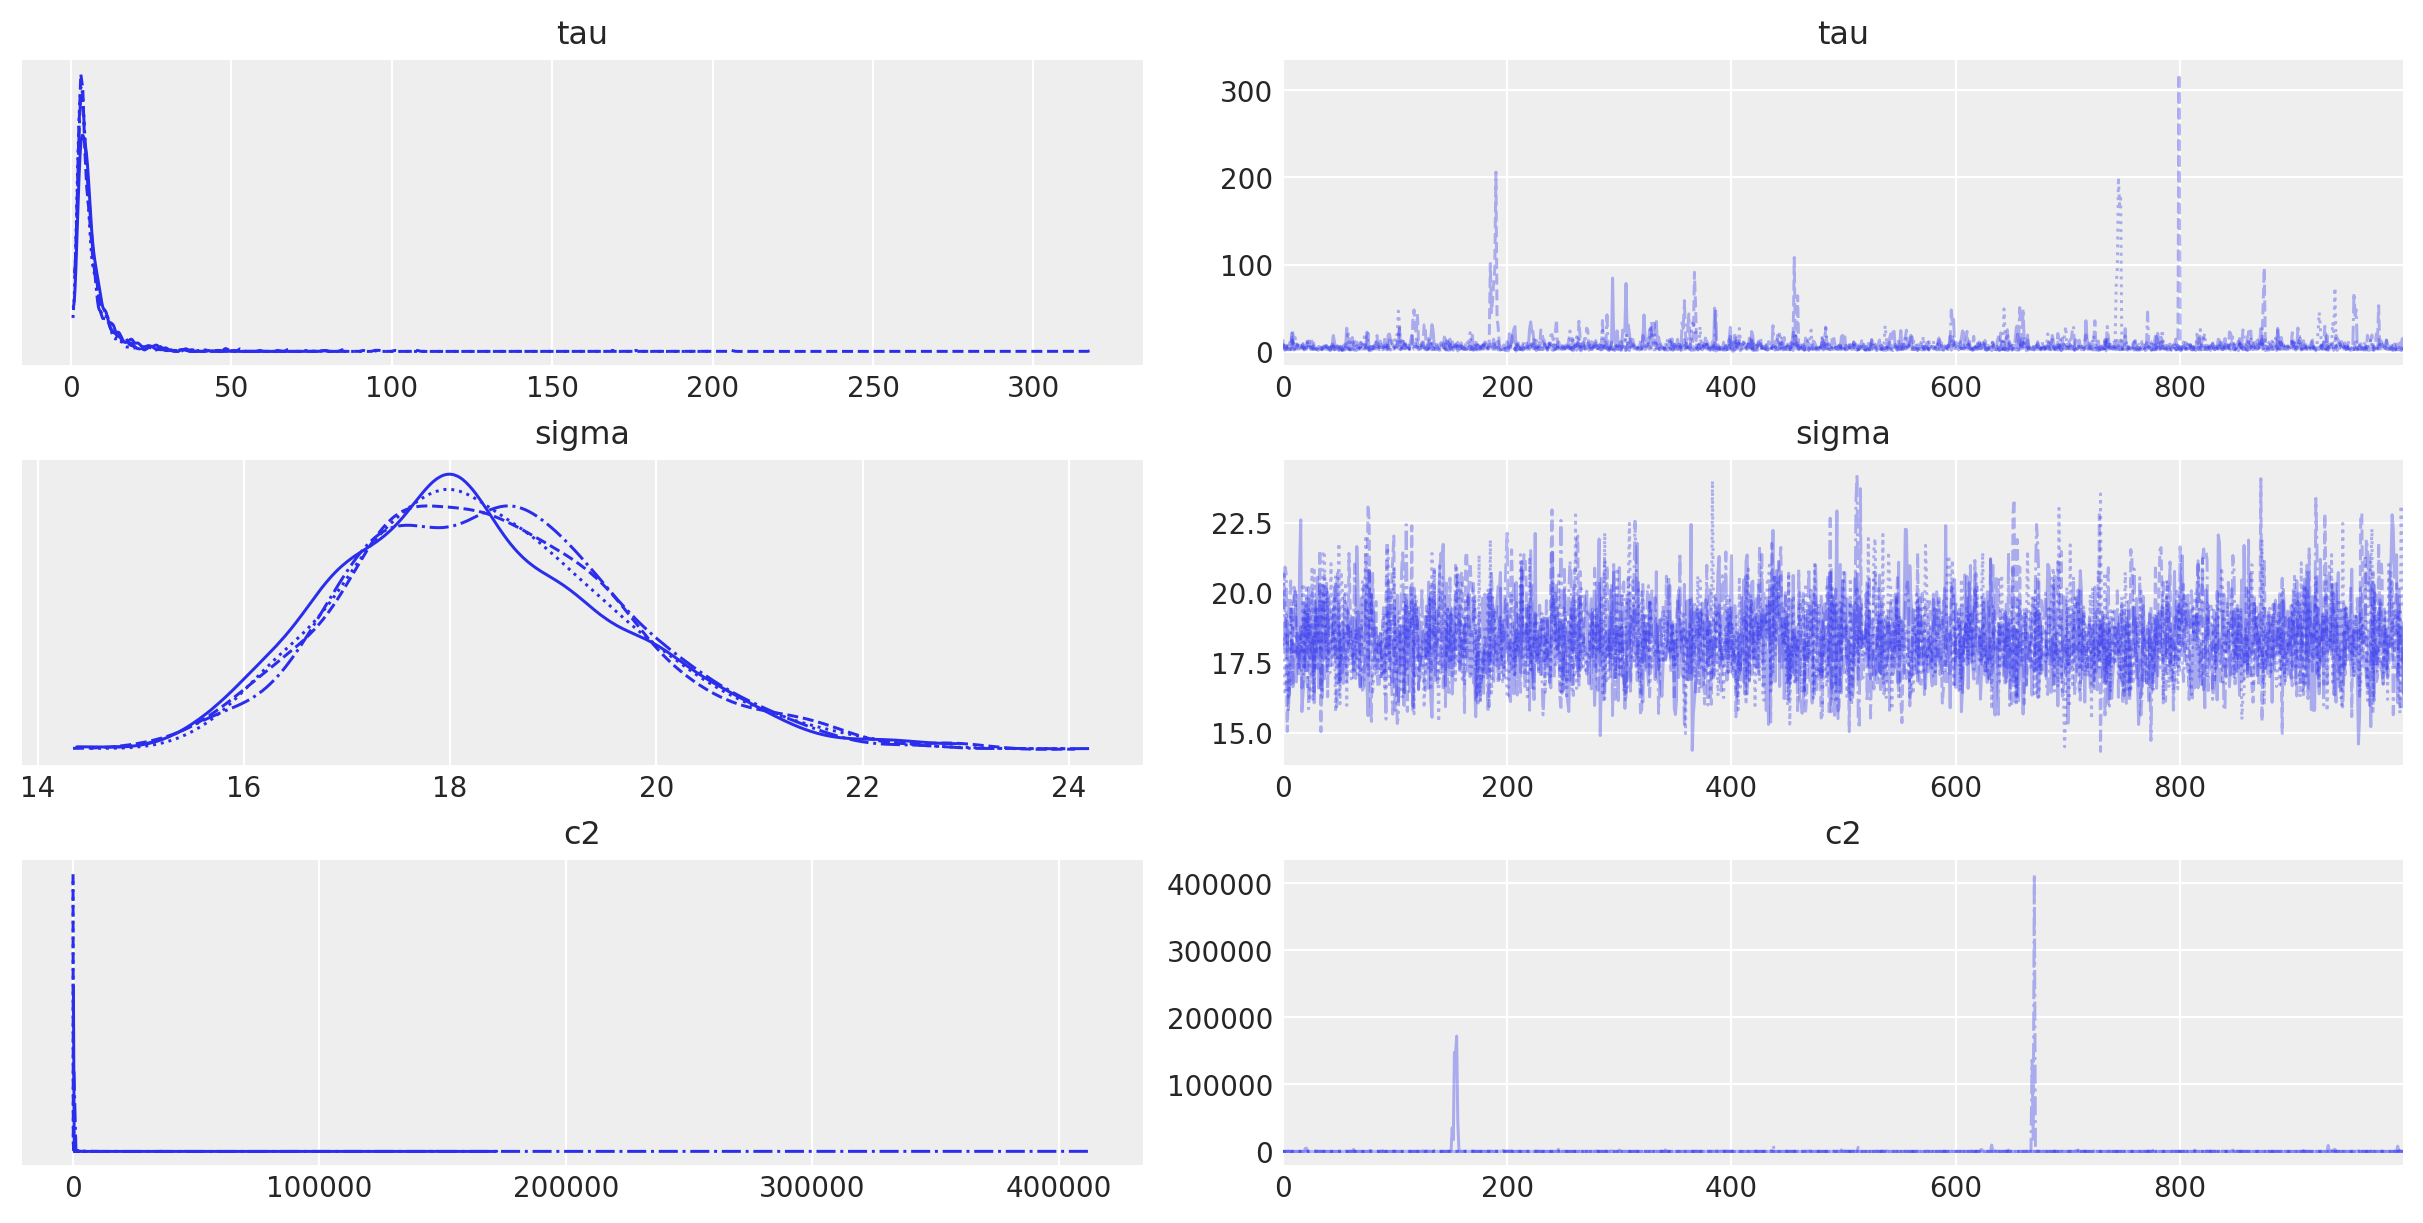

In [13]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

Do these look okay? Well, each of the densities on the left side for each parameter look pretty similar to the others, which means they have converged to the same posterior distribution (be it the correct one or not). The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values. Note that `c2` and `tau` occasionally sample extreme values, but this is expected from heavy-tailed distributions.

The next easy model-checking step is to see if the NUTS sampler performed as expected. An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribution. If it was not, one runs the risk of biased posterior estimates when parts of the posterior are not visited with adequate frequency. The plot shows two density estimates: one is the marginal energy distribution of the sampling run and the other is the distribution of the energy transitions between steps. This is all a little abstract, but all we are looking for is for the distributions to be similar to one another. Ours does not look too bad.

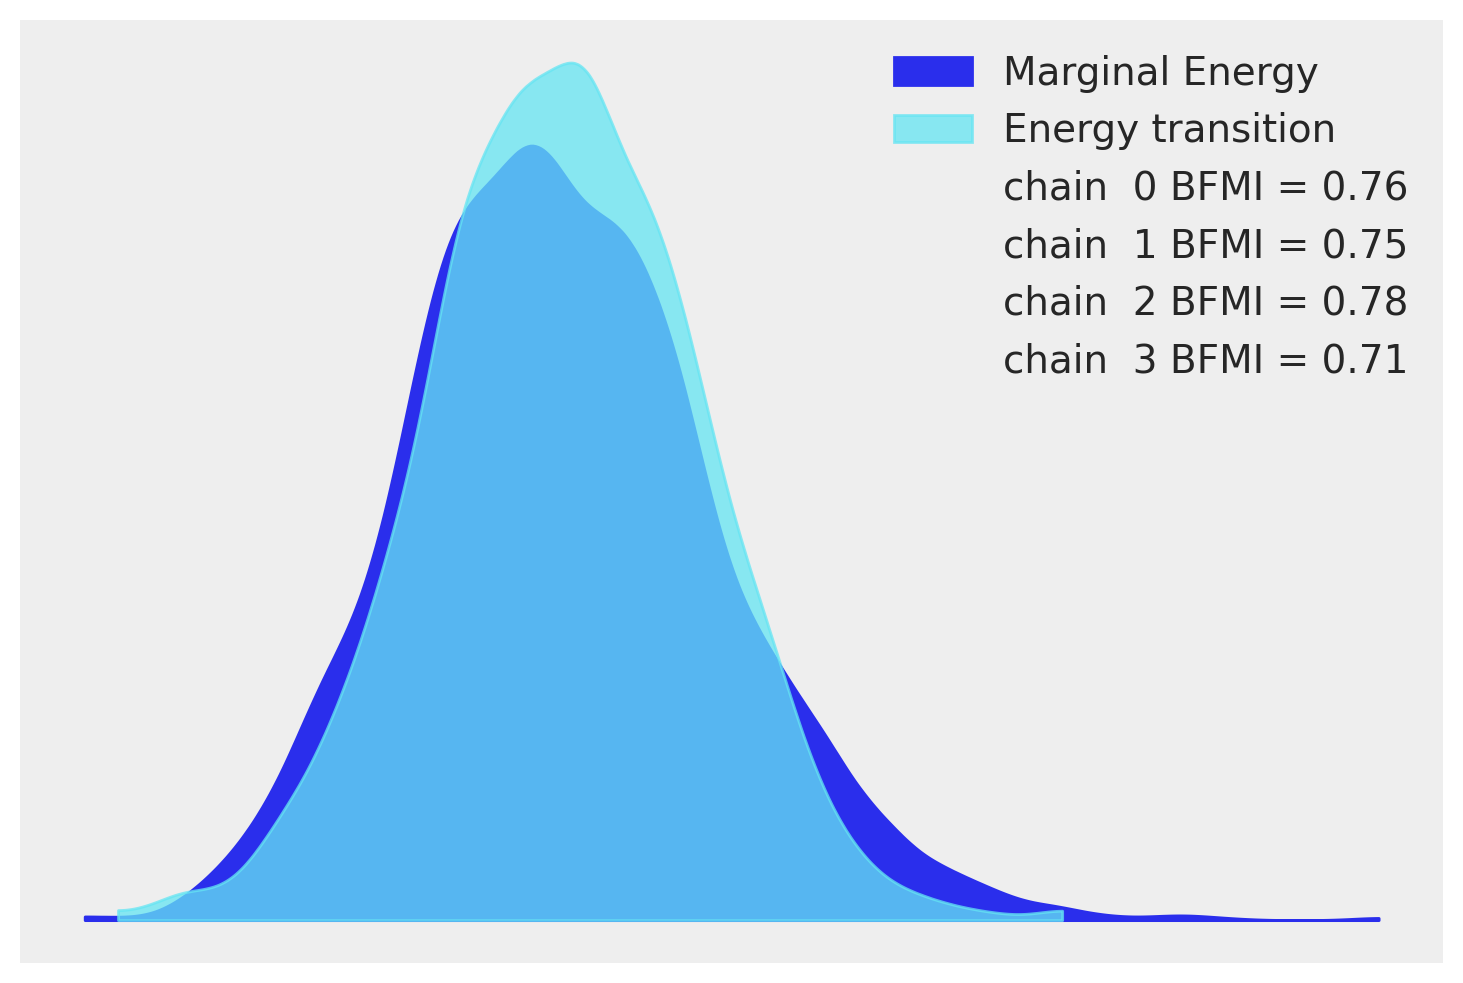

In [14]:
az.plot_energy(idata);

Ultimately, we are interested in the estimates of `beta`, the set of predictor coefficients. Passing `beta` to `plot_trace` would generate a very crowded plot, so we will use `plot_forest` instead, which is designed to handle vector-valued parameters.

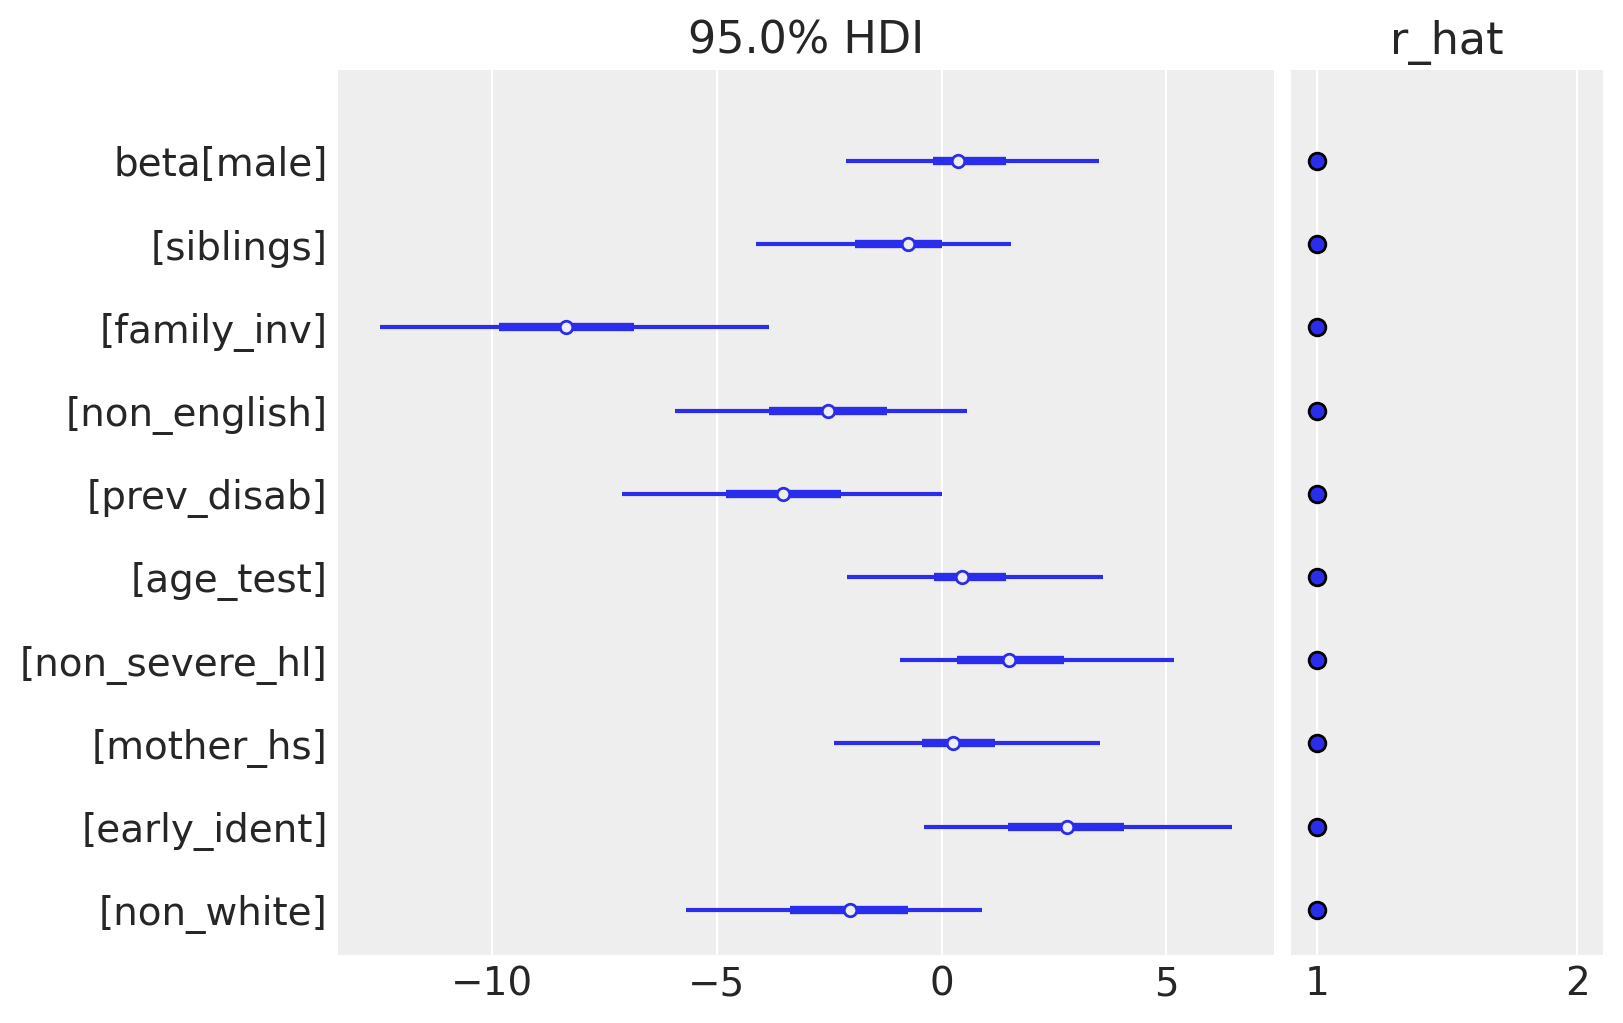

In [15]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

The posterior distribution of coefficients reveal some factors that appear to be important in predicting test scores. Family involvement (`family_inv`) is large and negative, meaning a larger score (which is related to poorer involvement) results in much worse test scores. On the other end, early identification of hearing impairment is positive, meaning that detecting a problem early results in better educational outcomes down the road, which is also intuitive. Notice that other variables, notably gender (`male`), age at testing (`age_test`), and the mother's educational status (`mother_hs`) have all been shrunk essentially to zero.